## Verison-3

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm.notebook import tqdm
import warnings

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.calibration import CalibratedClassifierCV

from nltk.tokenize import TweetTokenizer


import gensim.downloader as api
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [3]:
df = pd.read_csv('../input/result_version_2.csv')
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,selected_1,selected_2,selected_3,selected_4,selected_5,selected_6,selected_7,selected_8,selected_9,selected_10
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,10.0,2.0,0.0,0.999983,0.857131,0.999983,1.0,1.0,14.0,0.965517
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4.0,5.0,3.0,0.857131,0.499996,0.499988,1.0,1.0,13.5,0.576923


In [4]:
api.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [5]:
embedding_model = api.load('glove-wiki-gigaword-100')

In [6]:
tokenizer = TweetTokenizer()

In [7]:
question1_embed = np.zeros((df.shape[0], 100))

for index, question in tqdm(enumerate(df['question1']), total=df.shape[0]):
    
    sent_vec = np.zeros((100))
    
    for word in tokenizer.tokenize(question):
        
        try:
            sent_vec += embedding_model[word]
        except:
            pass
    
    question1_embed[index] = sent_vec

In [8]:
question2_embed = np.zeros((df.shape[0], 100))

for index, question in tqdm(enumerate(df['question2']), total=df.shape[0]):
    
    sent_vec = np.zeros((100))
    
    for word in tokenizer.tokenize(question):
        
        try:
            sent_vec += embedding_model[word]
        except:
            pass
    
    question2_embed[index] = sent_vec

In [9]:
q1_col_names = []

for i in range(100):
    
    name = f'q1_embed_{i}'
    q1_col_names.append(name)
    
q2_col_names = []

for i in range(100):
    
    name = f'q2_embed_{i}'
    q2_col_names.append(name)

In [10]:
for i,j,index in zip(q1_col_names, q2_col_names, range(100)):
    
    df[i] = question1_embed[:, index]
    df[j] = question2_embed[:, index]

In [11]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,selected_1,selected_2,selected_3,selected_4,...,q1_embed_95,q2_embed_95,q1_embed_96,q2_embed_96,q1_embed_97,q2_embed_97,q1_embed_98,q2_embed_98,q1_embed_99,q2_embed_99
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,10.0,2.0,0.0,0.999983,...,2.095641,0.597351,0.108956,0.087606,-5.669494,-5.676273,7.7238,6.83062,3.565189,3.763739
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4.0,5.0,3.0,0.857131,...,0.128997,-0.363727,-3.072056,-1.771393,-5.285466,-1.094756,4.1422,4.64534,2.107620,2.093928


In [12]:
df.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2'], inplace=True)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(df, df['is_duplicate'], 
                                                    stratify=df['is_duplicate'], 
                                                    test_size=0.3, random_state=1) 

x_train.drop(columns='is_duplicate', inplace=True)
x_test.drop(columns='is_duplicate', inplace=True)

In [31]:
lr = LogisticRegression(n_jobs=-1, verbose=10)

In [32]:
lr.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.0min finished


LogisticRegression(n_jobs=-1, verbose=10)

In [33]:
y_pred = lr.predict(x_test)

In [34]:
y_pred_prob = lr.predict_proba(x_test)

In [37]:
log_loss(y_test, y_pred_prob)

0.4327065505419373

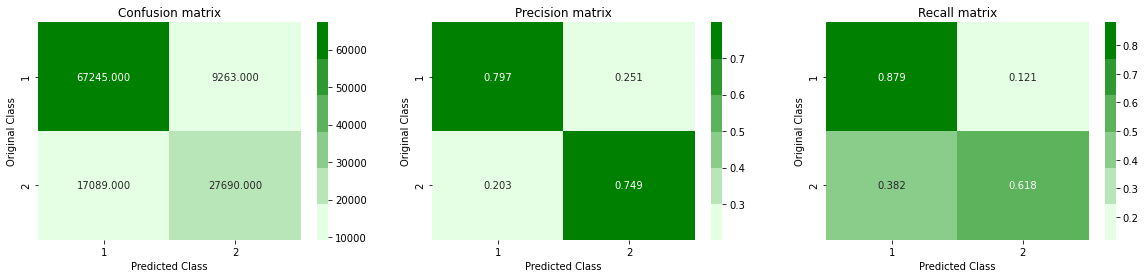

In [38]:
plot_confusion_matrix(y_test, y_pred)